In [2]:
import sys
from sklearn.manifold import TSNE
import numpy as np
import os
import random
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.functional as F
import numpy as np
from improved_diffusion.font_classifier import FontClassifier_LitModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

In [12]:
# Test
model_dir = 'lightning_logs/font_classifier/resnet50_800/version_3/checkpoints'
epoch = 14
# find the ckpt starting with epoch=2
ckpt = [c for c in os.listdir(model_dir) if c.startswith(f'epoch={epoch}')][0]
model = FontClassifier_LitModel(model_type='resnet50')
model = model.load_from_checkpoint(os.path.join(model_dir, ckpt),model_type='resnet50')
model.model.use_fc = False


In [13]:
trainer = pl.Trainer(devices=[2],fast_dev_run=False)
trainer.test(model)
result = np.array(model.result)
np.array(model.result_label).dump(os.path.join(model_dir,f'epoch={epoch}-encoder_result_labels.npy'))
result.dump(os.path.join(model_dir,f"epoch={epoch}-encoder_result.npy"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 3850/3850 [18:35<00:00,  3.45it/s]


# TSNE

In [14]:
result_data = np.load(os.path.join(model_dir,f"epoch={epoch}-encoder_result.npy"),allow_pickle=True)
result_labels = np.load(os.path.join(model_dir,f"epoch={epoch}-encoder_result_labels.npy"),allow_pickle=True)
tsne = TSNE()
print(result_data)
print(result_labels)

[[ 0.18860567 -0.23686241 -0.29608002 ... -0.40700805  0.34839612
  -0.0256662 ]
 [-0.12832841 -0.0690184  -0.38150135 ... -0.28303337  0.4830569
  -0.28969026]
 [ 0.0461078  -0.22151755 -0.04737598 ... -0.18160605  0.35530582
  -0.13861123]
 ...
 [-0.31469372 -0.615179    0.52858937 ...  0.29294503  0.01168251
   0.24592452]
 [-0.15467678 -0.6365062   0.22618841 ...  0.30739263 -0.12654939
   0.30118403]
 [ 0.13666263 -0.93737578  0.54594791 ...  0.29802498  0.07252494
   0.21011172]]
['寒蝉手拙体' '寒蝉手拙体' '寒蝉手拙体' ... '仓耳非白W01' '仓耳非白W01' '仓耳非白W01']


In [15]:
unique_labels = np.unique(result_labels)
unique_label_idces_list = []
mu_list = []
std_list = []
pts_list = []

for label in unique_labels:
    idces = [i for i in range(len(result_labels)) if result_labels[i] == label]
    mu_list.append(np.mean(result_data[idces],0))
    std_list.append(np.std(result_data[idces],0))
    idces = [idx for idx in idces if np.linalg.norm(result_data[idx]-mu_list[-1]) < np.linalg.norm(std_list[-1])*1]
    pts = result_data[idces]
    pts_list.append(pts)
    unique_label_idces_list.append(np.array(idces))
pts_list = np.concatenate(pts_list)
unique_label_idces_list = np.concatenate(unique_label_idces_list)
print(pts_list.shape)
print(unique_label_idces_list.shape)

(53071, 1024)
(53071,)


In [16]:
print(unique_labels)
print(len(unique_labels))
unique_label_2_index = {label: i for i, label in enumerate(unique_labels)}
result_labels = [unique_label_2_index[label] for label in result_labels]
print(result_labels)

['851tegaki_zatsu_normal_0883' '三极力量体简-粗' '三极泼墨体' '三极素纤简体' '三极行楷简体-粗'
 '云峰寒蝉体' '云峰静龙行书' '云峰飞云体' '京華老宋体_KingHwa_OldSong 1' '今年也要加油鸭' '仓耳与墨W01'
 '仓耳与墨W02' '仓耳与墨W03' '仓耳与墨W04' '仓耳与墨W05' '仓耳周珂正大榜书' '仓耳小丸子' '仓耳舒圆体W01'
 '仓耳舒圆体W02' '仓耳舒圆体W03' '仓耳舒圆体W04' '仓耳舒圆体W05' '仓耳非白W01' '仓耳非白W02' '仓耳非白W03'
 '仓耳非白W04' '仓耳非白W05' '优设好身体' '优设标题圆' '优设标题黑' '优设鲨鱼菲特健康体' '刘欢卡通手书2' '包图小白体'
 '千图厚黑体' '千图小兔体' '千图笔锋手写体' '千图纤墨体' '千图雪花体' '千图马克手写体' '宅在家粉條甜' '宅在家麦克笔'
 '寒蝉宽黑体' '寒蝉手拙体' '寒蝉高黑体' '小可奶酪体商用免费@庆科字体' '庞门正道标题体3' '庞门正道真贵楷体' '庞门正道粗书体6'
 '庞门正道细线体' '庞门正道轻松体' '手书体' '摄图摩登小方体(免费商用)' '文道潮黑' '新叶念体' '杨任东竹石体-Bold'
 '杨任东竹石体-Extralight' '杨任东竹石体-Heavy' '杨任东竹石体-Light' '杨任东竹石体-Medium'
 '杨任东竹石体-Regular' '杨任东竹石体-Semibold' '汇文明朝体' '沐瑶随心手写体' '清松手写体1' '清松手写体2'
 '清松手写体3' '清松手写体4' '清松手写体5' '清松手写体6' '清松手写体6p' '演示夏行楷' '演示斜黑体' '演示春风楷'
 '演示秋鸿楷' '瑞美加张清平硬笔楷书' '瑞美加张清平硬笔行书' '素材集市康康体3']
77
[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,

In [17]:
tsne_out = tsne.fit_transform(result_data)
np.save(os.path.join(model_dir,f"epoch={epoch}-tsne_out.npy"),tsne_out)
print(tsne_out.shape)

(61600, 2)


In [18]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure()
    #print(np.min(data, 0), np.max(data, 0))
    #print(np.min(data, 1), np.max(data, 1))
    ax = plt.subplot(111)
    colormap = plt.cm.get_cmap('hsv')
    plt.scatter(data[:, 0], data[:, 1],c= label,s=1,cmap=colormap)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.legend()
    return fig

/tmp/ipykernel_12425/2836485317.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('hsv')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


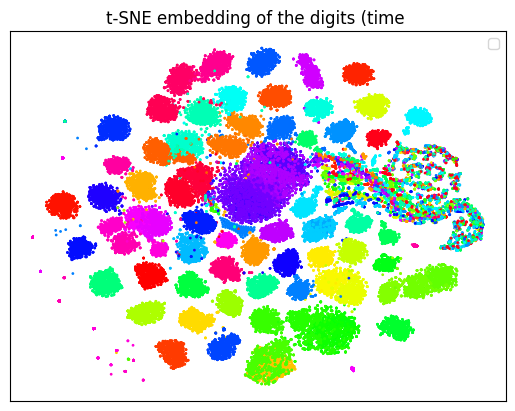

: 

In [19]:
n_start = 0
n_stop = 123

tsne_out_part = tsne_out[800*n_start:800*n_stop]
result_labels_part = result_labels[800*n_start:800*n_stop]
result_labels_part = [label - n_start for label in result_labels_part]
fig = plot_embedding(tsne_out_part, [(int(i))/(n_stop-n_start) for i in result_labels_part],
                         't-SNE embedding of the digits (time ')
